# **Met Office Historic Weather Station Analysis**

- Scrape historic weather station data from Met Office website.
- Collate data from several statoins for more robust dataset.
- Parse, clean, and visualise raw data for analysis.

## *Setup & Requesting Data*

In [4]:
import httpx
from selectolax.parser import HTMLParser
import pandas as pd
import numpy as np
from io import StringIO
from matplotlib import pyplot as plt
from matplotlib import colors as mcol
from matplotlib import rc
from matplotlib import cm
import os

# Setting working directory
os.chdir('/home/jamesbuchanan/Documents/coding-projects/met-weather-scraping')

# Requesting data
url = 'https://www.metoffice.gov.uk'\
    '/pub/data/weather/uk/climate/stationdata/braemardata.txt'
headers = {
    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:109.0)'\
    'Gecko/20100101 Firefox/119.0'
}

# Getting text data from request
braemar_response = httpx.get(url)
raw_data_braemar = braemar_response.text

## *Data Loading & Cleaning*

In [5]:
# This section removes the description header, removes returns and symbols,
# and formats commas into comma-seperated value (csv) format.

# Manual parsing
parsed_data_braemar = (raw_data_braemar
 .split('\n', 6)[6]
 .replace(' ', ',') 
 .replace(',,', ',')
 .replace(',,', ',')
 .replace(',,', ',')
 .replace('---', 'NaN') # Not working correctly
 .replace('\r\n,', '\n')
 .replace(',\n', '\n')
 .replace('*', '')
)

# Converting to pandas dataframe
df_braemar = pd.read_csv(StringIO(parsed_data_braemar), sep = ',')

# Cleaning column names
colnames = list(df_braemar.columns)
colnames.append('Provisional')
colnames.pop(0)

# Assigning new column names
df_braemar.columns = colnames

# Cleaning braemar data
df_braemar = (df_braemar
    .iloc[1:]
    .rename(columns = str.lower)
    .rename(columns = {
        'yyyy': 'year',
        'mm': 'month',
        'tmax': 'max_temp',
        'tmin': 'min_temp',
        'af': 'air_frost_days',
        'rain': 'rainfall',
        'sun': 'sun_hours'
        })
    .assign(
        year = (
            lambda df_: df_['year'].astype(int).astype(str)
            ),
        month = (
            lambda df_: df_['month'].astype(str)
            ),
        max_temp = (
            lambda df_: df_['max_temp'].str.replace('*', '').astype('float16')
            ),
        min_temp = (
            lambda df_: df_['min_temp'].str.replace('*', '').astype('float16')
            )
        )
)

## *Initial plotting*

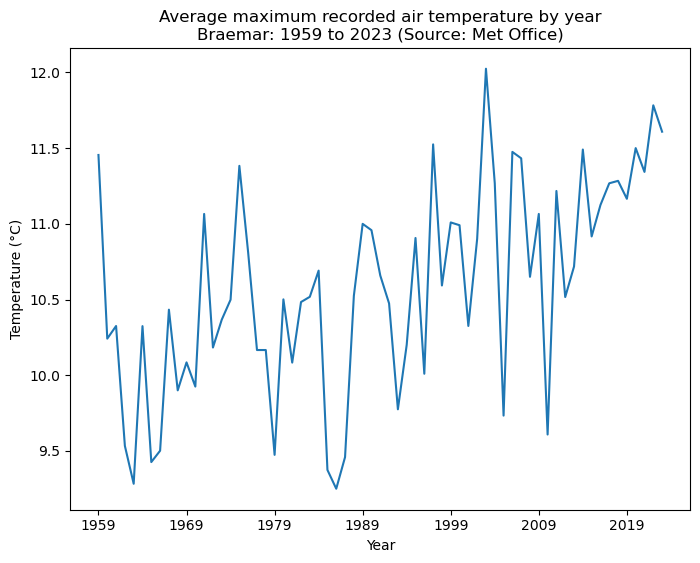

In [6]:
plt.figure(figsize = (8, 6))

ax = (df_braemar
    .groupby('year')
    ['max_temp']
    .mean()
    .plot()
)

ax.set_title('Average maximum recorded air temperature by year\nBraemar: 1959 to 2023 (Source: Met Office)')
ax.legend().set_visible(False)
ax.set_xlabel('Year')
ax.set_ylabel('Temperature (°C)')

plt.show()

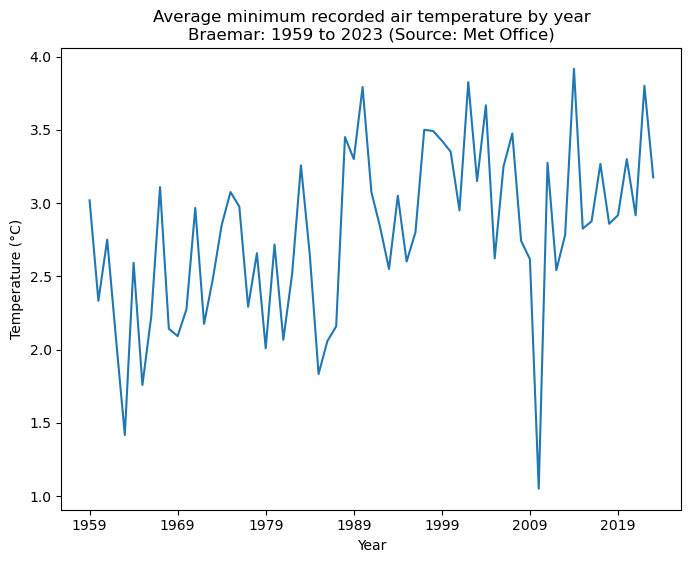

In [7]:
plt.figure(figsize = (8, 6))

ax = (df_braemar
    .groupby('year')
    ['min_temp']
    .mean()
    .plot()
)

ax.set_title('Average minimum recorded air temperature by year\nBraemar: 1959 to 2023 (Source: Met Office)')
ax.legend().set_visible(False)
ax.set_xlabel('Year')
ax.set_ylabel('Temperature (°C)')

plt.show()

## *Tidy plotting*

In [8]:
# Creating plotting variables
avg_min_temp = (df_braemar
    .groupby('year')
    ['min_temp']
    .mean()
    .reset_index(drop = True)
    .squeeze()
)

avg_max_temp = (df_braemar
    .groupby('year')
    ['max_temp']
    .mean()
    .reset_index(drop = True)
    .squeeze()
)

abs_min_temp = (df_braemar
    .groupby('year')
    ['min_temp']
    .min()
    .reset_index(drop = True)
    .squeeze()
)

abs_max_temp = (df_braemar
    .groupby('year')
    ['max_temp']
    .max()
    .reset_index(drop = True)
    .squeeze()
)

avg_overall_temp = (avg_max_temp + avg_min_temp) / 2

delta_t = avg_max_temp - avg_min_temp

year = (df_braemar
    ['year']
    .drop_duplicates()
    .astype('int')
    .reset_index(drop = True)
    .squeeze()
)

In [9]:
# Set plotting style
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["font.family"] = 'Roboto Condensed'

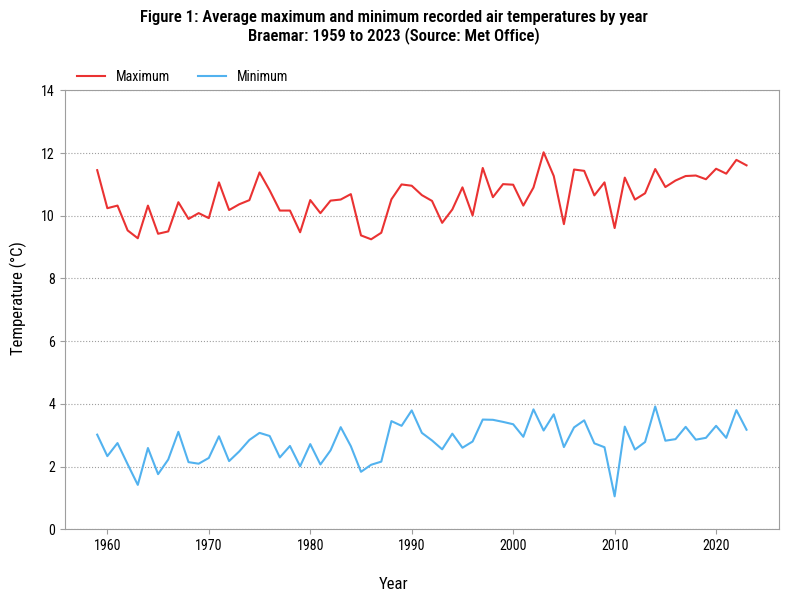

In [10]:
# Setting chart layout
fig, ax = plt.subplots(
    figsize = (8, 6),
    tight_layout = True
)

# Plot axes
ax.plot(year, avg_max_temp, lw = 1.5, label = 'Maximum', color = '#ea3232')
ax.plot(year, avg_min_temp, lw = 1.5, label = 'Minimum', color = '#52b2ef')

# Plot labels
fig.suptitle(
    'Figure 1: Average maximum and minimum recorded air temperatures by year'\
    '\nBraemar: 1959 to 2023 (Source: Met Office)',
    fontweight = 'semibold')
fig.supxlabel('Year')
fig.supylabel('Temperature (°C)')

# Border, grid, and face colours
ax.grid(
    which = 'major', 
    axis = 'y', 
    linestyle = 'dotted', 
    color = '#9e9e9e'
    )
ax.set_facecolor('white')
ax.tick_params(color = '#9e9e9e')
# Drawing plot boundary
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_color('#9e9e9e')

# Setting axis limits
ax.set_ylim(bottom = 0, top = 14)

# Legend
plt.legend(
    loc = 'upper left', 
    bbox_to_anchor=(0, 1.075), 
    frameon = False, 
    ncols = 2
)

plt.show()

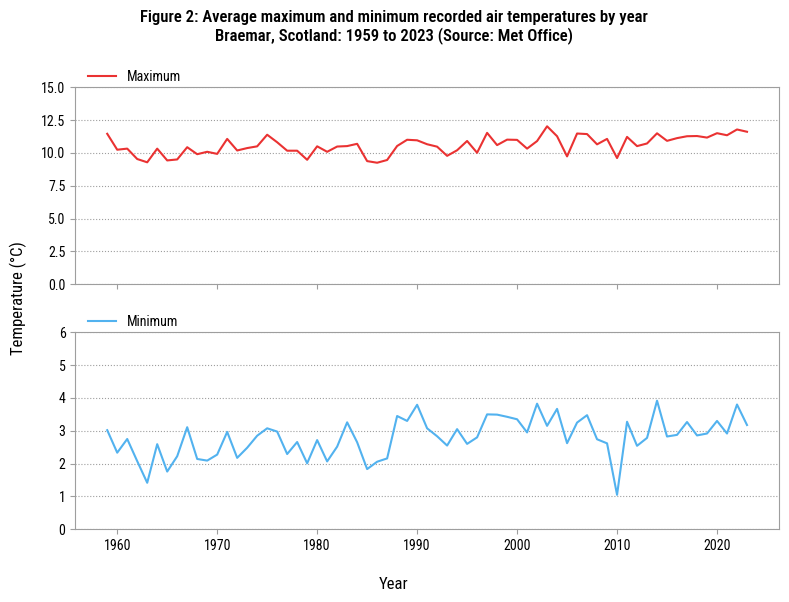

In [11]:
# Setting chart layout
fig, (ax1, ax2) = plt.subplots(
    2,
    figsize = (8, 6),
    sharex = True, 
    tight_layout = True
)

# Plot axes
ax1.plot(year, avg_max_temp, lw = 1.5, label = 'Maximum', color = '#ea3232')
ax2.plot(year, avg_min_temp, lw = 1.5, label = 'Minimum', color = '#52b2ef')

fig.suptitle('Figure 2: Average maximum and minimum recorded air temperatures by year\nBraemar, Scotland: 1959 to 2023 (Source: Met Office)',
             fontweight = 'semibold')
fig.supxlabel('Year')
fig.supylabel('Temperature (°C)')

# Border, grid, and face colours
ax1.grid(which = 'major', 
        axis = 'y', 
        linestyle = 'dotted', 
        color = '#9e9e9e')
ax1.set_facecolor('white')
ax1.tick_params(color = '#9e9e9e')
# Drawing plot boundary
for axis in ['top', 'bottom', 'left', 'right']:
  ax1.spines[axis].set_color('#9e9e9e')

ax2.grid(
    which = 'major', 
    axis = 'y', 
    linestyle = 'dotted', 
    color = '#9e9e9e')
ax2.set_facecolor('white')
ax2.tick_params(color = '#9e9e9e')
# Drawing plot boundary
for axis in ['top', 'bottom', 'left', 'right']:
  ax2.spines[axis].set_color('#9e9e9e')

ax1.set_ylim(bottom = 0, top = 15)
ax2.set_ylim(bottom = 0, top = 6)

ax1.legend(
    loc = 'upper left', bbox_to_anchor=(0, 1.15), frameon = False, ncols = 2
)
ax2.legend(
    loc = 'upper left', bbox_to_anchor=(0, 1.15), frameon = False, ncols = 2
)

plt.show()

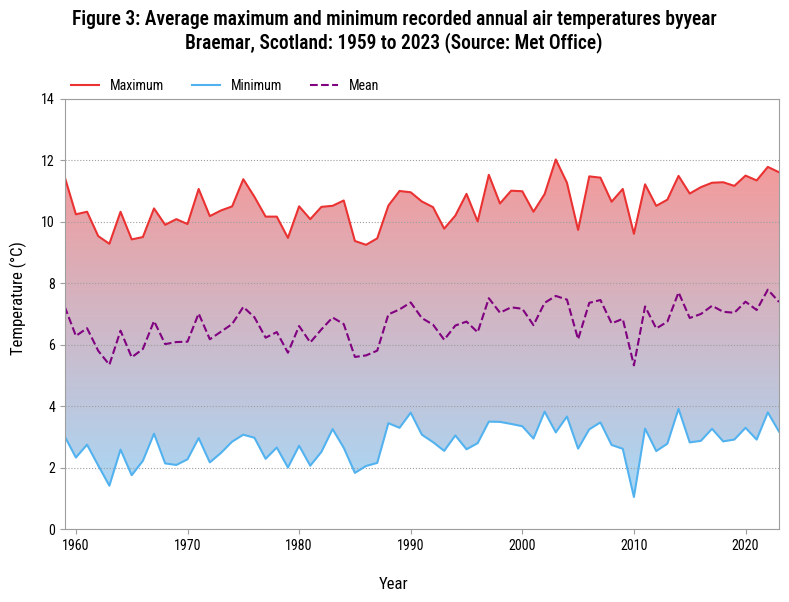

In [12]:
# Setting chart layout
fig, ax = plt.subplots(
    figsize = (8, 6), 
    tight_layout = True
)

# Plot axes
ax.plot(
    year, avg_max_temp, 
    lw = 1.5, 
    label = 'Maximum', 
    color = '#ea3232')
ax.plot(
    year, avg_min_temp, 
    lw = 1.5, 
    label = 'Minimum', 
    color = '#52b2ef')
ax.plot(
    year, avg_overall_temp, 
    lw = 1.5, 
    linestyle = '--', 
    label = 'Mean', 
    color = '#800080')

# Plot labels
fig.suptitle(
    'Figure 3: Average maximum and minimum recorded annual air temperatures by'\
    'year\nBraemar, Scotland: 1959 to 2023 (Source: Met Office)',
    fontweight = 'semibold',
    fontsize = 14)
fig.supxlabel('Year')
fig.supylabel('Temperature (°C)')

# Border, grid, and face colours
ax.grid(
    which = 'major', 
    axis = 'y', 
    linestyle = 'dotted', 
    color = '#9e9e9e')
ax.set_facecolor('white')
ax.tick_params(color = '#9e9e9e')
# Drawing plot boundary
for axis in ['top', 'bottom', 'left', 'right']:
  ax.spines[axis].set_color('#9e9e9e')

# Shading
rectangle = np.linspace(0, 2023, 14)
cm1 = mcol.LinearSegmentedColormap.from_list(
    'Temperature Map', ['#52b2ef', '#ea3232']
)
polygon = ax.fill_between(
    year, avg_max_temp, avg_min_temp, lw = 0, color = 'none'
)
xlim = (year.min(), year.max())
ylim = plt.ylim()
verts = np.vstack([p.vertices for p in polygon.get_paths()])
gradient = ax.imshow(
    np.linspace(0, 1, 256).reshape(-1, 1), 
    cmap = cm1, 
    alpha = 0.5, 
    aspect = 'auto', 
    origin = 'lower',
    extent = [verts[:, 0].min(), 
    verts[:, 0].max(), 
    verts[:, 1].min(), 
    verts[:, 1].max()])
gradient.set_clip_path(polygon.get_paths()[0], transform = plt.gca().transData)
plt.xlim(xlim)
plt.ylim(ylim)

# Setting axis limits
ax.set_ylim(bottom = 0, 
            top = 14)

# Legend
plt.legend(
    loc = 'upper center', 
    bbox_to_anchor = (0.225, 1.075), 
    frameon = False, 
    ncols = 3
)

plt.show()

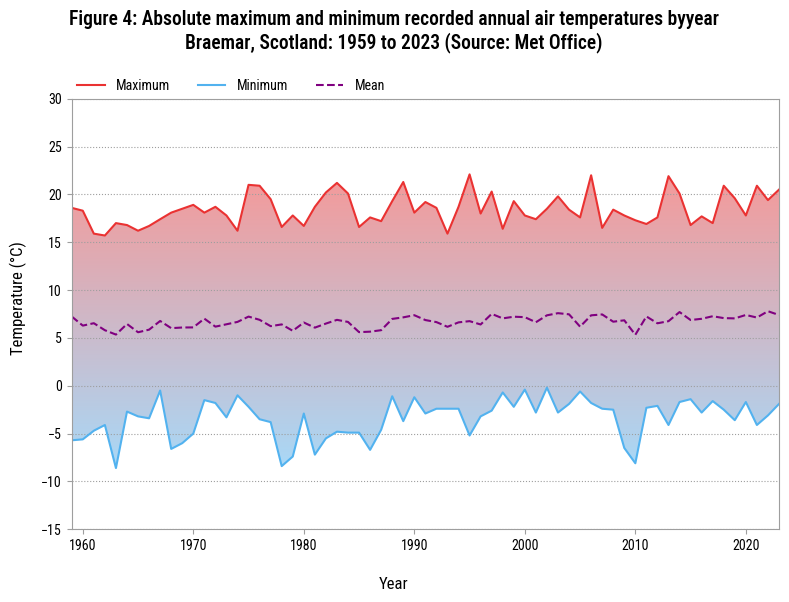

In [13]:
# Setting chart layout
fig, ax = plt.subplots(
    figsize = (8, 6), 
    tight_layout = True
)

# Plot axes
ax.plot(
    year, abs_max_temp, 
    lw = 1.5, 
    label = 'Maximum', 
    color = '#ea3232')
ax.plot(
    year, abs_min_temp, 
    lw = 1.5, 
    label = 'Minimum',
    color = '#52b2ef')
ax.plot(
    year, avg_overall_temp, 
    lw = 1.5, 
    linestyle = '--', 
    label = 'Mean', 
    color = '#800080')

# Plot labels
fig.suptitle(
    'Figure 4: Absolute maximum and minimum recorded annual air temperatures by'\
    'year\nBraemar, Scotland: 1959 to 2023 (Source: Met Office)',
    fontweight = 'semibold',
    fontsize = 14)
fig.supxlabel('Year')
fig.supylabel('Temperature (°C)')

# Border, grid, and face colours
ax.grid(
    which = 'major', 
    axis = 'y', 
    linestyle = 'dotted', 
    color = '#9e9e9e'
)
ax.set_facecolor('white')
ax.tick_params(color = '#9e9e9e')
# Drawing plot boundary
for axis in ['top', 'bottom', 'left', 'right']:
  ax.spines[axis].set_color('#9e9e9e')

# Shading
rectangle = np.linspace(0, 2023, 14)
cm1 = mcol.LinearSegmentedColormap.from_list(
    'Temperature Map', ['#52b2ef', '#ea3232']
)
polygon = ax.fill_between(
    year, abs_max_temp, abs_min_temp, lw = 0, color = 'none'
)
xlim = (year.min(), year.max())
ylim = plt.ylim()
verts = np.vstack([p.vertices for p in polygon.get_paths()])
gradient = ax.imshow(
    np.linspace(0, 1, 256).reshape(-1, 1), 
    cmap = cm1, 
    alpha = 0.5, 
    aspect = 'auto', 
    origin = 'lower',
    extent = [verts[:, 0].min(), 
    verts[:, 0].max(), 
    verts[:, 1].min(), 
    verts[:, 1].max()])
gradient.set_clip_path(
    polygon.get_paths()[0], 
    transform = plt.gca().transData
)
plt.xlim(xlim)
plt.ylim(ylim)

# Setting axis limits
ax.set_ylim(
    bottom = -15, 
    top = 30
)

# Legend
plt.legend(
    loc = 'upper center', 
    bbox_to_anchor = (0.225, 1.075), 
    frameon = False, 
    ncols = 3
)

plt.show()